In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from pelops.datasets.featuredataset import FeatureDataset
from pelops.experiment_api.experiment import ExperimentGenerator
from pelops.datasets import chip
from collections import defaultdict
from scipy.spatial.distance import cosine, euclidean
from matplotlib.font_manager import FontProperties
from tqdm import tnrange, tqdm_notebook

In [2]:
# do the comparisons between chips
def is_correct_match(cam1, cam2, topN=2, verbose=False, comparison='cosine'):
    similarities = []
    for cam1_chip in cam1:
        cam1_feat = fd.get_feats_for_chip(cam1_chip)
        for cam2_chip in cam2:
            cam2_feat = fd.get_feats_for_chip(cam2_chip)
            if comparison == 'cosine':
                similarity = 1 - cosine(cam1_feat, cam2_feat)
            elif comparison == 'euclidian':
                similarity = -1*abs(euclidean(cam1_feat, cam2_feat))
            else:
                raise ValueError('invalid comparison name')
            similarities.append((similarity, cam1_chip, cam2_chip))
            
    similarities.sort(reverse=True)
    for i, (similarity, chip1, chip2) in enumerate(similarities):
        # return best_match
        if chip1.car_id == chip2.car_id:
            if verbose:
                return i, similarities
            else:
                return i
    raise ValueError("Huh?")


In [3]:
# do EXPERIMENTS, determine 
def preCMC(a,EXPERIMENTS=100):
   
    num_downs = defaultdict(int)
    for i in range(EXPERIMENTS):
        a = eg.generate()
        num_down = is_correct_match(a[0], a[1])
        num_downs[num_down] += 1
        
    keys = sorted(num_downs)
    vals = [num_downs[key] for key in keys]
    return((keys,np.array(vals)/EXPERIMENTS))

In [4]:
# Generate unprocessed CMC curves 
# the data needs to be summed to make the correct
# CMC curve
def makeManyPreCMC(a,N=100,EXPERIMENTS=100):
    experimentHolder = []
    for experiment in tnrange(N):
        experimentHolder.append(preCMC(a,EXPERIMENTS=EXPERIMENTS))
    return experimentHolder

In [5]:
# finalize creation of the CMC curves
# generate statistics on the CMC curves
# return all
def makeCMCStats(experimentHolder,itemsPerCamera):
    comparisons = itemsPerCamera*itemsPerCamera
    stats = np.zeros((len(experimentHolder),comparisons))

    for index,(keys,vals) in enumerate(experimentHolder):
        for keyIndex in range(len(keys)):
            stats[index,keys[keyIndex]] = vals[keyIndex]


    for index in range(len(stats[:,])):
        total_sum = 0.0
        offsetlen = len(stats[0])
        for sample in range(offsetlen):
            total_sum += stats[index,sample] 
            stats[index,sample] = total_sum         

    gdata = np.zeros((3,comparisons))

    for i in range(comparisons):
        gdata[1,i] = np.average(stats[:,i])
    for i in range(comparisons):
        stddev  = np.std(stats[:,i])
        gdata[0,i] = gdata[1,i] - stddev
        gdata[2,i] = gdata[1,i] + stddev
    
    return (stats,gdata)

In [ ]:
DATASETFILE = '/some/path/aFile'
ITEMSPERCAMERA = 10
YRANDOM=1024
CAMERAS=2
DROPPED=0
CMC=100
EXPERIMENTS=1000

In [9]:
#do the math
fd = FeatureDataset(DATASETFILE)
eg = ExperimentGenerator(fd, CAMERAS, ITEMSPERCAMERA, DROPPED, YRANDOM)
a = eg.generate()
experimentHolder = makeManyPreCMC(a,N=CMC,EXPERIMENTS=EXPERIMENTS)
stats,gdata = makeCMCStats(experimentHolder,ITEMSPERCAMERA)

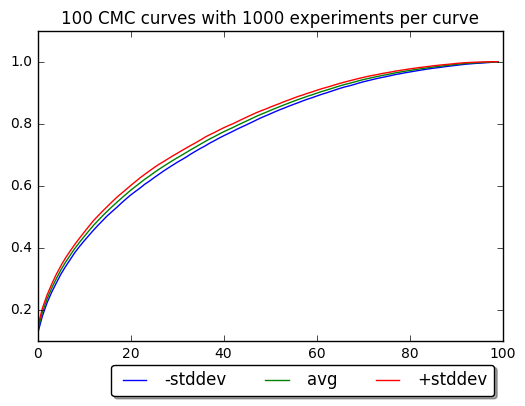

In [10]:
#make the plots
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(gdata.transpose())
plt.title('{} CMC curves with {} experiments per curve'.format(CMC,EXPERIMENTS))
ax.legend(('-stddev','avg','+stddev'),bbox_to_anchor=(1, -0.05),
          fancybox=True, shadow=True, ncol=5)